In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt
sns.set()

from IPython import display
import time
import itertools

from scipy.stats import multivariate_normal
from scipy.spatial import distance_matrix

# Data visualization

In [2]:
data_train = pd.read_csv('EMGaussian.data', sep=' ', header=None)
data_train.columns=['x', 'y']
data_test = pd.read_csv('EMGaussian.test', sep=' ', header=None)
data_test.columns=['x', 'y']

<IPython.core.display.Javascript object>


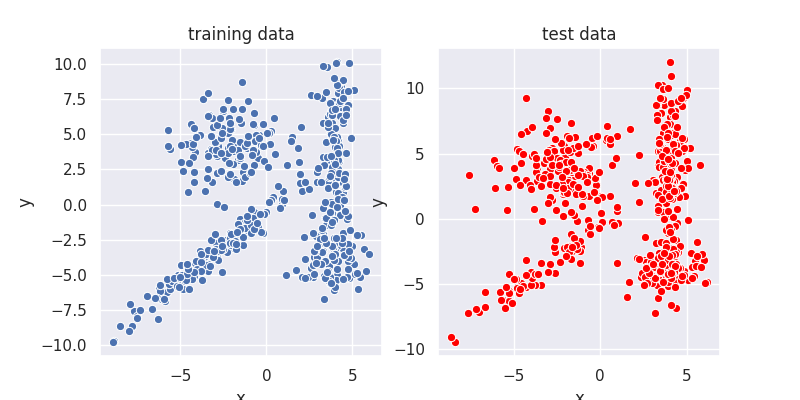

In [3]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title('training data')
sns.scatterplot(x="x", y="y", data=data_train)
plt.subplot(122)
plt.title('test data')
sns.scatterplot(x="x", y="y", data=data_test, color='red');

# K-means

In [4]:
def Jfunc(X, mu, z, k):
    J = 0
    for i in range(k):
         J += np.sum(np.power(np.linalg.norm(X[z==i] - mu[i,:], axis=1), 2))
    return J

In [5]:
def kmeans(X, k, eps, display='all', timing=0.4):
    
    # initialization
    mu = X[np.random.randint(0, X.shape[0],k), :]
    convergence = False
    
    if display=='all':
        fig = plt.figure()
        ax = fig.add_subplot(111)
        palette = ['red', 'blue', 'green', 'purple', 'yellow', 'orange']
        plt.ion()
        ax.clear()
        ax.scatter(x=X[:, 0], y=X[:, 1], c='red')
        ax.scatter(x=mu[:, 0], y=mu[:, 1], c='black', marker='X')
        fig.canvas.draw()  # draw
        time.sleep(timing)  #sleep
        fig.show();
        
    j = np.inf

    while not(convergence):
        # optimize over z
        z = np.argmin(distance_matrix(X, mu), axis=1)
        
        if display=='all':
            ax.clear()  # clear
            sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=z, palette=palette)
            fig.canvas.draw()  # draw
            time.sleep(timing)  #sleep
        
        #optimize over mu
        for i in range(0,k):
            mu[i, :] = X[z==i].mean(axis=0)
            
        if display == 'all':
            ax.scatter(x=mu[:, 0], y=mu[:, 1], c='black', marker='X')
            fig.canvas.draw()  # draw
            time.sleep(timing) 
            
        #convergence evaluation
        if np.abs(j - Jfunc(X, mu, z, k))<eps:
            convergence = True
        else:
            j = Jfunc(X, mu, z, k)
        
        if display == 'all':
            fig.canvas.set_window_title('J: {}'.format(j))
    
    return mu, z

<IPython.core.display.Javascript object>


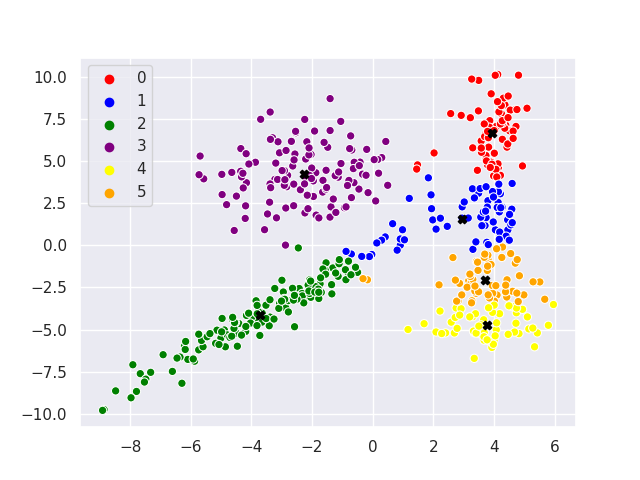

In [6]:
mu, z = kmeans(data_train.values, 6, 0.1, display='all', timing=0.2)

### Experiments with several random initializations

In [7]:
# compute a transportation distance between two point clouds with the same number of points
def transport_distance(mu1, mu2):
    dist = np.inf
    n_points = mu1.shape[0]
    
    for permutation in itertools.permutations(list(range(n_points))):
        dist = min(dist, np.sum((mu1 - mu2[np.array(permutation)]) ** 2))
        
    return dist

In [8]:
n_runs = 10
K = 4
mu_tab = []
J_tab = []

for _ in range(n_runs):
    mu, z = kmeans(data_train.values, K, 0.1, display=None)
    mu_tab.append(mu)
    J_tab.append(Jfunc(data_train.values, mu, z, K))

max_transport_dist = 0
for i in range(n_runs):
    for j in range(n_runs):
        transport_dist = transport_distance(mu_tab[i], mu_tab[j])
        max_transport_dist = max(max_transport_dist, transport_dist)

print('{} clusters'.format(K))
print('Mean distortion: {:.0f}  standard deviation: {:.2f}'.format(np.mean(J_tab), np.std(J_tab)))
print('Maximum transportation distance between centers: {:.2f}'.format(max_transport_dist))

4 clusters
Mean distortion: 3239  standard deviation: 1.24
Maximum transportation distance between centers: 0.23


In [9]:
n_runs = 10
K = 6
mu_tab = []
J_tab = []

for _ in range(n_runs):
    mu, z = kmeans(data_train.values, K, 0.1, display=None)
    mu_tab.append(mu)
    J_tab.append(Jfunc(data_train.values, mu, z, K))

max_transport_dist = 0
for i in range(n_runs):
    for j in range(n_runs):
        transport_dist = transport_distance(mu_tab[i], mu_tab[j])
        max_transport_dist = max(max_transport_dist, transport_dist)

print('{} clusters'.format(K))
print('Mean distortion: {:.0f}  standard deviation: {:.2f}'.format(np.mean(J_tab), np.std(J_tab)))
print('Maximum transportation distance between centers: {:.2f}'.format(max_transport_dist))

/home/leo-alberge/.local/share/virtualenvs/PGM-oNoHVeFf/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
/home/leo-alberge/.local/share/virtualenvs/PGM-oNoHVeFf/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


6 clusters
Mean distortion: 3370  standard deviation: 4553.34
Maximum transportation distance between centers: inf


# Gaussian mixtures

In [11]:
cmaps_dict = {'blue':'Blues',
              'red':'Reds',
              'green':'Greens',
              'purple':'Purples',
              'grey': 'Greys',
              'orange':'Oranges'}

palette = ['red', 'blue', 'green', 'purple', 'grey', 'orange']

In [12]:
def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """
    Create a grid in the form of a list of points stored in a 2D array
    """

    if data is not None:
        xmax, xmin,  = np.max(data[:, 0]), np.min(data[:, 0])
        ymax, ymin = np.max(data[:, 1]), np.min(data[:, 1])
        
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1./step), 
                       np.arange(ymin, ymax, (ymax-ymin)*1./step))
    
    grid = np.c_[x.ravel(), y.ravel()]

    return grid, x, y

In [19]:
class GaussianMixture():
    
    def __init__(self, X, k, covariance_mode, eps=10e-3, n_itermax=1000, display='all', timing=0.1):
        
        # input parameters
        self.X = X
        self.k = k
        self.covariance_mode = covariance_mode
        self.eps = eps  # convergence threshold
        self.n_itermax = n_itermax 
        
        
        # kmeans initialization
        mu, tau = kmeans(X, k, 0.1, display=None)
       
        self.tau = np.zeros(pd.get_dummies(tau).values.shape)

        # Gaussians mean and covariance matrix initialization
        self.mus = mu.T

        if covariance_mode == 'isotrope':
            self.sigmas = np.ones(k)
        else:
            self.sigmas = np.ones((k, self.X.shape[1], self.X.shape[1]))
            for j in range(self.k):
                self.sigmas[j] = np.eye(self.X.shape[1])
        self.pis = np.ones(k)/k

        # display settings
        if display=='all':
            self.timing = timing
            self.set_display()
            #self.display()
        
    def set_display(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        if self.covariance_mode == 'isotrope':  # allow to visualize isotropy
            self.ax.axis('scaled')
        self.palette =  np.random.permutation(palette)[:self.k].tolist()
        plt.ion()

        # grid used to display ellipses containing a certain percentage
        # of the mass of the Gaussian distribution
        grid, x_grid, y_grid = make_grid(data=self.X, step=100)
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.grid = grid
        self.ax.axis([np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)])
            
    def display(self):
        self.ax.clear()
        for j in range(self.k):
            self.ax.contour(self.x_grid,
                            self.y_grid,
                            multivariate_normal.pdf(self.grid, 
                                                    mean=self.mus[:, j], 
                                                    cov=self.sigmas[j]).reshape(self.x_grid.shape),
                            levels = None,
                            alpha=0.6,
                            linestyles='solid',
                            cmap =cmaps_dict[self.palette[j]])

        sns.scatterplot(x=self.X[:, 0], y=self.X[:, 1], 
                        hue=np.argmax(self.tau, axis=1), palette=self.palette)
        
        self.ax.scatter(x=self.mus[0, :], y=self.mus[1, :], c='black', marker='X')
        
        self.fig.canvas.draw()  # draw
        time.sleep(self.timing)  # sleep
    
        
    def fit(self,verbose=True):
        loglikold = -np.inf
        for i in range(self.n_itermax):
            ## e-step
            for j in range(self.k):
                self.tau[:, j] = self.pis[j] * multivariate_normal.pdf(self.X, 
                                                                   mean=self.mus[:, j], 
                                                                   cov=self.sigmas[j])
            self.tau = self.tau / self.tau.sum(axis=1).reshape(-1, 1)
            
            loglik = 0
            for j in range(self.k):
                log_pdf = multivariate_normal.logpdf(self.X, mean=self.mus[:, j], cov=self.sigmas[j])
                loglik +=((self.tau[:,j]* log_pdf).sum() + self.tau[:,j].sum()* np.log(self.pis[j]))-(self.tau[:,j]*np.log(self.tau[:,j])).sum()
            if verbose:
                print(loglik)
            if loglik < loglikold - self.eps:
                print('error')
            if loglik < loglikold + self.eps:
                break
            
            loglikold = loglik;

            self.pis = self.tau.mean(axis=0)
            for j in range(self.k):
                self.mus[:,j] = (self.X * (self.tau[:, j].reshape(-1, 1))).sum(axis=0) / self.tau[:,j].sum()

            if self.covariance_mode == 'isotrope':
                for j in range(self.k):
                    X_centered_norm = np.power(np.linalg.norm(self.X - self.mus[:, j], axis=1),2)
                    self.sigmas[j] = np.average(X_centered_norm, weights=self.tau[:, j])/2
            else:
                for j in range(self.k):
                    X_centered = self.X - self.mus[:,j]
                    sigma_i = (X_centered.T.dot(np.diag(self.tau[:, j]))).dot(X_centered)
                    sigma_i = sigma_i / np.diag(self.tau[:, j]).sum()
                    self.sigmas[j] = sigma_i
                    
            self.display()
    def jfunc(self):
        loglik = 0
        for j in range(self.k):
            log_pdf = multivariate_normal.logpdf(self.X, mean=self.mus[:, j], cov=self.sigmas[j])
            loglik +=((self.tau[:,j]* log_pdf).sum() + self.tau[:,j].sum()* np.log(self.pis[j]))-(self.tau[:,j]*np.log(self.tau[:,j])).sum()
        return loglik


### Isotropic case

<IPython.core.display.Javascript object>


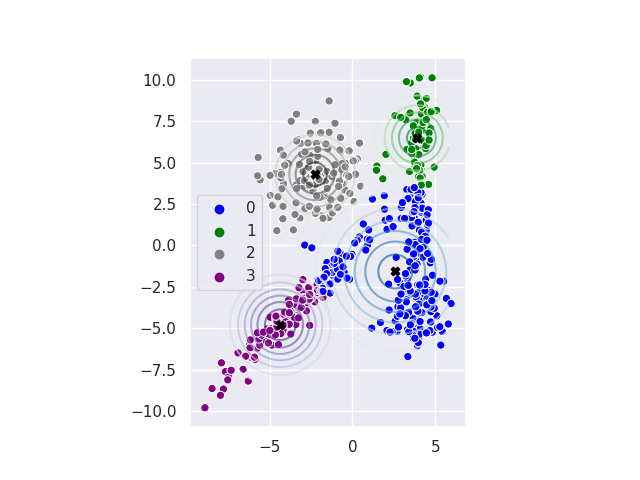

-3220.642323349591
-2656.1854787786156
-2653.8465249867336
-2653.3620803187823
-2653.157755526338
-2653.0491283118263
-2652.9724390643214
-2652.902055785121
-2652.8273866243117
-2652.743570714792
-2652.6479947717344
-2652.5390626073026
-2652.415773517761
-2652.2775828279127
-2652.12435521169
-2651.9563399452586
-2651.774140910381
-2651.5786725882176
-2651.3711024516456
-2651.1527849711683
-2650.9251944224766
-2650.689863544917
-2650.4483335173104
-2650.2021183957077
-2649.9526847234847
-2649.701444911041
-2649.4497613972844
-2649.198957578431
-2648.950330970896
-2648.705164025899
-2648.464728459806
-2648.230279982902
-2648.0030419468685
-2647.7841785841606
-2647.5747608337915
-2647.3757296650224
-2647.187862701624
-2647.0117494300475
-2646.8477784359497
-2646.696137541484
-2646.556825248502
-2646.4296702463835
-2646.314355231746
-2646.2104417768514
-2646.117394052545
-2646.0346003840014
-2645.9613925387926


KeyboardInterrupt: 

In [20]:
g = GaussianMixture(data_train.values, 4, 'isotrope')
g.fit()
print('Log likelihood (training set): {}'.format(g.jfunc()))
g.X = data_test.values
print('Log likelihood (test set): {}'.format(g.jfunc()))

### General case

<IPython.core.display.Javascript object>


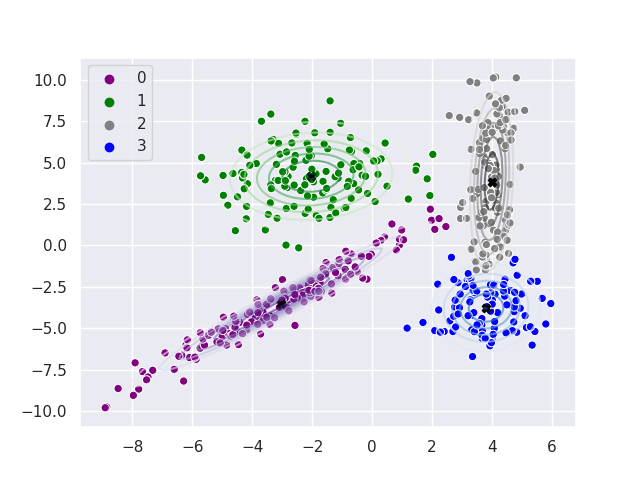

-3220.642323349591
-2394.658321943298
-2357.0174106817394
-2339.247608822101
-2334.340560856249
-2332.413793257963
-2331.140714090351
-2330.1802520601623
-2329.4584131297224
-2328.9321210762237
-2328.5583544221618
-2328.297493031414
-2328.117204914407
-2327.9931379212435
-2327.907823359327
-2327.8490781067494
-2327.808530133905
-2327.7804630048186
-2327.760978819267
-2327.747415770577
-2327.7379508505933
Log likelihood: -2327.7379508505933
Log likelihood (test set): -18939.56046198331


In [21]:
g = GaussianMixture(data_train.values, 4, 'non-isotrope')
g.fit()
print('Log likelihood: {}'.format(g.jfunc()))
g.X = data_test.values
print('Log likelihood (test set): {}'.format(g.jfunc()))

In [ ]:
g.set_display()
g.display()

In [21]:
np.save('../homework3/labels.npy',np.argmax(g.tau, axis=1))